> __Purpose:__ This NB takes forever to run. The functionality of this ended up being to create and plot the results, and then I saved the results so that I could use them in a fresh new NB without all this code and crazy run times.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
import os
import h5py
import copy
import statistics

import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import re
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score

#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

In [2]:
final_update = 16

## Load Data

In [3]:
def load_final_model_performances(cv_results_path, filename, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            a_group_key = list(f.keys())
            #if i==0:
            #    print(a_group_key)
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_model_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_model_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass

    return extraction_dict


In [4]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

# CROSS
cpfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
cfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold')
cnofl_model_dict = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
ifa_model_dict = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold')
inofl_model_dict = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold')


# Adversarial Modeling

In [7]:
# LinearSVC() --> Was failling to converge...

In [121]:
def execute_linkage_attack(extractration_dict, num_kfolds=7, stratification=False, i_modulus=3, i_lt_or_eq='eq', 
                           my_metrics_columns=['Algorithm', 'Update Number', 'CV Acc', 'Test Acc'], 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, full_test_df=pd.DataFrame(), min_n_samples=10):

    keys = extractration_dict.keys()
    num_updates_lst = []
    for key in keys:
        num_updates_lst.append(len(extractration_dict[key]))
        # ORIGINAL CODE:
        #num_updates_lst.append(len(extractration_dict[list(extractration_dict.keys())[0]]))
    mode_update = statistics.mode(num_updates_lst)
    max_update = max(num_updates_lst)
    if max_update == mode_update:  # Eg this is a poor man's proxy for if this is the NOFL case
        num_updates = mode_update
    else:
        num_updates = min(max_update, int(statistics.mean(num_updates_lst) + statistics.stdev(num_updates_lst)))  # int() rounds down
    print(f"{num_updates} unique models")
    
    # Initialize a list of empty DataFrames for each user group
    dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(num_updates)]
    
    # Regular expression pattern to extract subject and fold
    #pattern = r"S(\d+)_client_local_model_log_fold(\d+)"
    pattern = r"(S\d+)_client_local_model_log_fold(\d+)"
    
    # Loop through keys and updates to populate the DataFrames
    for key_idx, key in enumerate(keys):
        key_len = len(extractration_dict[key])
        match = re.search(pattern, key)  # Extract the subject and fold using regex
        if match:
            #subject = int(match.group(1))  # e.g., '0', '1', '10'
            subject = match.group(1)  # e.g., 'S0', 'S1', 'S10'
            fold = int(match.group(2))  # e.g., '0', '1', '2'
            for update_number in range(num_updates): 
                if update_number >= key_len:
                    continue
                else:
                    user_data = np.ravel(extractration_dict[key][update_number])
                    dec_flattened_list[update_number].loc[len(dec_flattened_list[update_number])] = [subject, fold, update_number, user_data]
    
    # Concat all the dfs into a single training input dataframe
    dec_flattened = pd.concat(dec_flattened_list, ignore_index=True, axis=0)
    flattened_input_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
    #print(expanded_dec_df.shape)
    #expanded_dec_df.head()
    
    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)
    
    # Adjust stop index to prevent overflow
    n_start_stop=(0, num_updates)
    n_stop = n_start_stop[1] - 1
    print(f"num_updates {num_updates}; n_start_stop {n_start_stop}; new n_stop {n_stop}")
    
    for i in range(n_start_stop[0], n_stop + 1):
        #print(f"Round i={i} of stop={n_start_stop[1]}")
    
        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")
    
            if i%i_modulus==0:
                print(f"Round i={i} of stop={n_start_stop[1]}")
                
                # Filter the dataframe to use data from updates <= i
                # TODO: DECIDE ON USING <, <=, OR BOTH!
                if i_lt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_lt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]
                test_df = flattened_input_df[flattened_input_df['Update Number'] == n_stop]  # Hold out the last update for testing
            else:
                # SKIP THE ENTIRE LOOP
                #print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
            test_df = full_test_df  
    
        X_train = train_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_train = train_df['Subject']
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']
    
        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            cv_scores = []
            for fold_num in range(num_kfolds):
                #print(f"Fold {fold_num}")
                train_fold = train_df[train_df['Fold'] != fold_num]
                val_fold = train_df[train_df['Fold'] == fold_num]
    
                if train_fold.shape[0] < min_n_samples:
                    # if model is KNN and num_train_samples < model.n_neighbors
                    # Adjust n_neighbors if necessary
                    #print(f"Adjusting n_neighbors to {num_train_samples} since it's smaller than n_neighbors.")
                    #model.set_params(n_neighbors=num_train_samples) 
                    
                    print(f"Not enough samples! Skipping this ruond")
                    continue
                elif val_fold.shape[0]==0:
                    print("Val fold empty! Skipping!")
                    # Clients are trained a different number of rounds, so the max may be much higher than the average
                    # Thus resulting in upper rounds not containing any instances of a specific fold (eg can't train the model the way it is expected here)
                    continue

                X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                y_train_fold = train_fold['Subject'].reset_index(drop=True)
    
                X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                y_val_fold = val_fold['Subject']
    
                # Fit model on the current training fold
                model.fit(X_train_fold, y_train_fold)
    
                # Evaluate on the validation fold
                score = model.score(X_val_fold, y_val_fold)
                cv_scores.append(score)
    
            # After evaluating all folds, calculate the average cross-validation score
            cv_avg_score = sum(cv_scores) / len(cv_scores)
    
            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)
    
            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Algorithm': [type(model).__name__],
                'Update Number': [i],
                'CV Acc': [cv_avg_score],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)
    
    return full_test_res_df


In [122]:
i_nofl = 5
i_fl = 50

In [123]:
cpfa_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)


127 unique models
num_updates 127; n_start_stop (0, 127); new n_stop 126
Round i=0 of stop=127
Round i=50 of stop=127
Round i=100 of stop=127


In [124]:
print(cpfa_res_df.shape)
cpfa_res_df.head()

(9, 4)


,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.0
1,DecisionTreeClassifier,0,0.071429,0.0
2,GradientBoostingClassifier,0,0.071429,0.0
3,KNeighborsClassifier,50,0.440476,0.0
4,DecisionTreeClassifier,50,0.559524,0.0


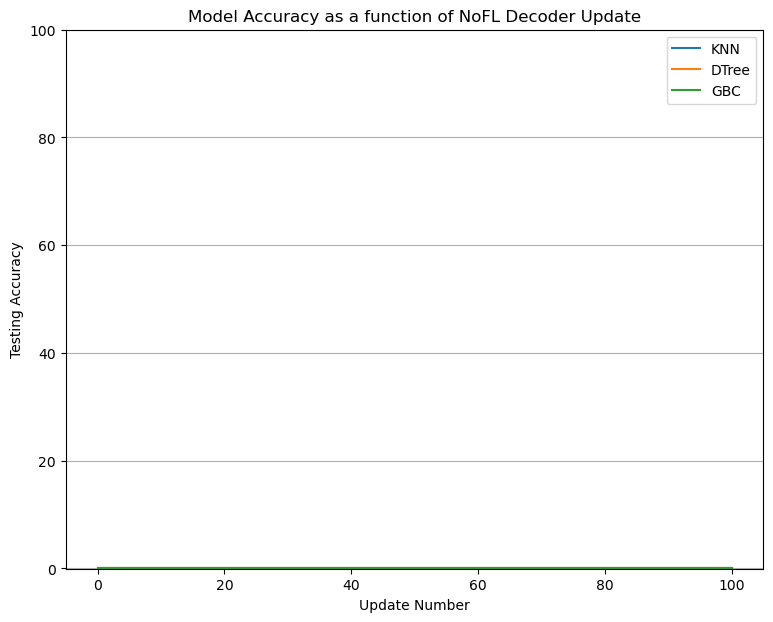

In [125]:
full_test_res_df = cpfa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [114]:
i_nofl = 5
i_fl = 50

cpfa_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)
cfa_res_df = execute_linkage_attack(cfa_model_dict, i_modulus=i_fl)
cnofl_res_df = execute_linkage_attack(cnofl_model_dict, i_modulus=i_nofl)
ipfa_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
ifa_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
inofl_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)

127 unique models
num_updates 127; n_start_stop (0, 127); new n_stop 126
Round i=0 of stop=127
Round i=50 of stop=127
Round i=100 of stop=127
127 unique models
num_updates 127; n_start_stop (0, 127); new n_stop 126
Round i=0 of stop=127
Round i=50 of stop=127
Round i=100 of stop=127
13 unique models
num_updates 13; n_start_stop (0, 13); new n_stop 12
Round i=0 of stop=13
Round i=5 of stop=13
Round i=10 of stop=13
98 unique models
num_updates 98; n_start_stop (0, 98); new n_stop 97
Round i=0 of stop=98
Round i=50 of stop=98
98 unique models
num_updates 98; n_start_stop (0, 98); new n_stop 97
Round i=0 of stop=98
Round i=50 of stop=98
13 unique models
num_updates 13; n_start_stop (0, 13); new n_stop 12
Round i=0 of stop=13
Round i=5 of stop=13
Round i=10 of stop=13


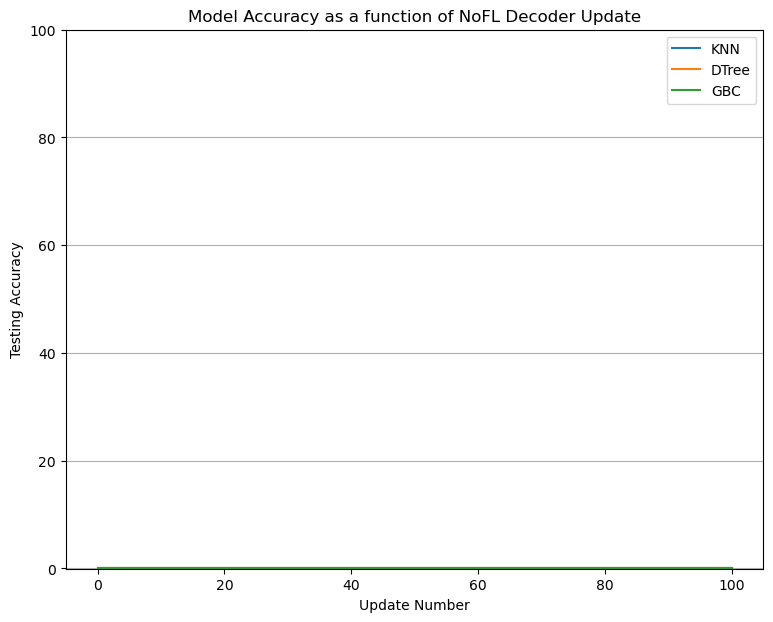

In [119]:
full_test_res_df = cpfa_res_df

knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
#plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

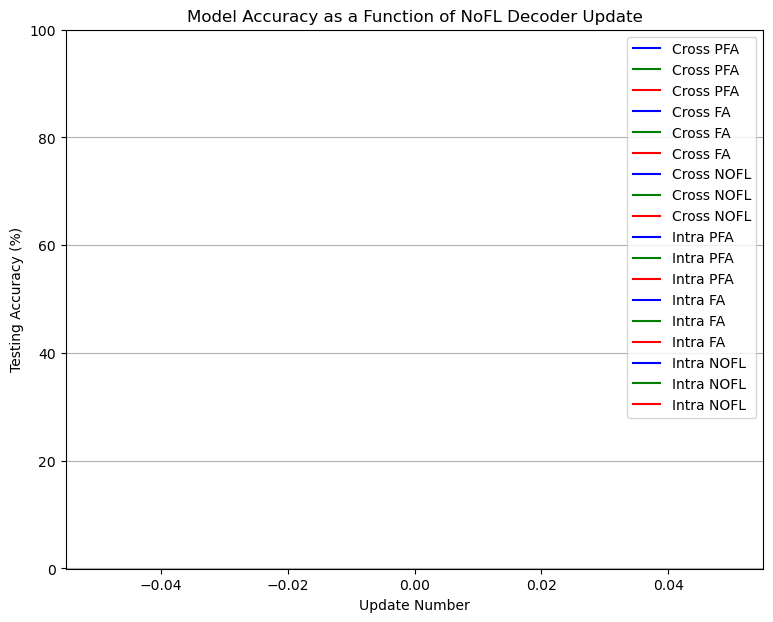

In [116]:

trial_dfs = [cpfa_res_df, cfa_res_df, cnofl_res_df, ipfa_res_df, ifa_res_df, inofl_res_df]  # Replace these with your actual dataframes

# Model names and corresponding colors
models = ['KNeighborsClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
colors = ['blue', 'green', 'red']  # Colors for KNN, DTree, GBC respectively
labels = ['Cross PFA', 'Cross FA', 'Cross NOFL', 'Intra PFA', 'Intra FA', 'Intra NOFL']

plt.figure(figsize=(9, 7))

# Loop through each trial dataframe and model to plot all curves
for i, trial_df in enumerate(trial_dfs):
    for color_idx, color in enumerate(colors):
        # Filter the dataframe for each model (Algorithm)
        model_df = trial_df[trial_df['Algorithm'] == model]
        
        # Plot the curve for this trial and model
        plt.plot(
            model_df['Update Number'], 
            model_df['Test Acc'], 
            label=f'{labels[i]}', 
            color=colors[color_idx],
            linestyle='-',  # Solid lines for consistency
            linewidth=1.5
        )

# Customize plot appearance
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy (%)')
plt.title('Model Accuracy as a Function of NoFL Decoder Update')
plt.legend(loc='best')  # , ncol=2 Adjust the number of columns to avoid overlapping labels
plt.show()


In [13]:
# THESE ARE CREATED ABOVE!
# CROSS
#cpfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
#cfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold')
#cnofl_model_dict = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
#ipfa_model_dict = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold')
#ifa_model_dict = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold')
#inofl_model_dict = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold')

i_nofl = 2
i_fl = 10

full_test_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(cfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(cnofl_model_dict, i_modulus=i_nofl)
full_test_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
full_test_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)



Round i=0 of stop=13
Round i=1 of stop=13
1 skipped for speed!
Round i=2 of stop=13
2 skipped for speed!
Round i=3 of stop=13
Round i=4 of stop=13
4 skipped for speed!
Round i=5 of stop=13
5 skipped for speed!
Round i=6 of stop=13
Round i=7 of stop=13
7 skipped for speed!
Round i=8 of stop=13
8 skipped for speed!
Round i=9 of stop=13
Round i=10 of stop=13
10 skipped for speed!
Round i=11 of stop=13
11 skipped for speed!
Round i=12 of stop=13


In [14]:
full_test_res_df

,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
1,DecisionTreeClassifier,0,0.071429,0.071429
2,GradientBoostingClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
4,DecisionTreeClassifier,3,0.928571,0.081633
5,GradientBoostingClassifier,3,0.989796,0.071429
6,KNeighborsClassifier,6,1.000000,0.346939
7,DecisionTreeClassifier,6,0.918367,0.071429
8,GradientBoostingClassifier,6,0.979592,0.071429
9,KNeighborsClassifier,9,0.969388,0.959184


In [15]:
knn_df = full_test_res_df[full_test_res_df['Algorithm']=='KNeighborsClassifier']
#svc_df = full_test_res_df[full_test_res_df['Algorithm']=='LinearSVC']
dt_df = full_test_res_df[full_test_res_df['Algorithm']=='DecisionTreeClassifier']
gbt_df = full_test_res_df[full_test_res_df['Algorithm']=='GradientBoostingClassifier']

In [16]:
print(knn_df.shape)
knn_df.head()

(5, 4)


,Algorithm,Update Number,CV Acc,Test Acc
0,KNeighborsClassifier,0,0.071429,0.071429
3,KNeighborsClassifier,3,1.000000,0.081633
6,KNeighborsClassifier,6,1.000000,0.346939
9,KNeighborsClassifier,9,0.969388,0.959184
12,KNeighborsClassifier,12,0.959184,0.959184


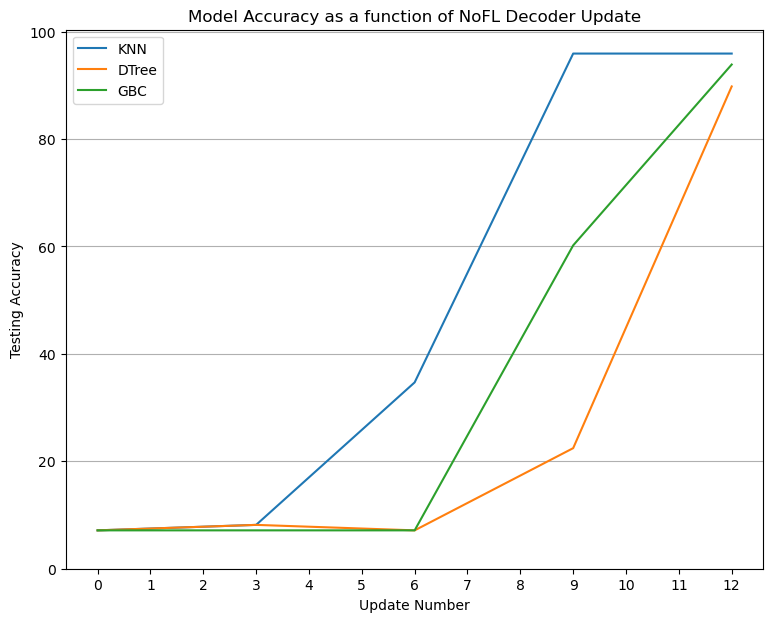

In [17]:
col_num = 1
my_x_updates = list(range(17))

plt.figure(figsize=(9,7))
plt.plot(knn_df['Update Number'], knn_df['Test Acc']*100, label='KNN')
plt.plot(dt_df['Update Number'], dt_df['Test Acc']*100, label='DTree')
plt.plot(gbt_df['Update Number'], gbt_df['Test Acc']*100, label='GBC')
plt.xticks(np.arange(0, num_updates, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [ ]:
assert(False)

In [ ]:
# RENAME / REWORK THESE!

#global_lr_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LogisticRegression()']
global_knn_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
#global_svc_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LinearSVC()']
global_dt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
global_gbt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']